In [1]:
import os
import glob
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights

# Utils

In [2]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print("Device used: ", device)

Device used:  cuda


In [3]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)

def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s ' % checkpoint_path)

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Visualization

In [5]:
def imageshow(sample):
  """ show the image of a sample """
  image = sample[0]
  label = sample[1]
  for t, m, s in zip(image, mean, std):
    t.mul_(s).add_(m)
  # reshape the img from (3, 32, 32) to (32, 32, 3)
  plt.imshow(np.transpose(image, (1, 2, 0)))
  plt.title(label)
  plt.show()

In [6]:
def batchshow(dataloader):
  """ show the images of a batch of sample """
  for images, labels in dataloader:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    for image in images:
      for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    # reshape the img from (3, 32, 32) to (32, 32, 3)
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

# Custom Dataset & DataLoader

In [7]:
class HW1P1B(Dataset):
    def __init__(self, dirpath, transform=None):
        """ Initialize dataset """
        self.filepaths = []
        self.classes = set()
        self.transform = transform

        for fp in glob.glob(dirpath + "/*.png"):
            self.filepaths.append(fp)
            fn = os.path.basename(fp)
            label = int(fn[0:fn.find('_')])
            self.classes.add(label)


    def __getitem__(self, index):
        """ Get a sample from the dataset """
        fp = self.filepaths[index]
        fn = os.path.basename(fp)
        image = Image.open(fp)
        label = int(fn[0:fn.find('_')])

        if self.transform is not None:
            image = self.transform(image)
        image.unsqueeze(0)
        
        return image, label
    
    def __len__(self):
        """ Get total number of samples in the dataset """
        return len(self.filepaths)

In [8]:
trainset = HW1P1B(
    dirpath="./hw1_data/p1_data/train_50",
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((-30, 30), expand=False),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
)
trainset_origin = HW1P1B(
    dirpath="./hw1_data/p1_data/train_50",
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
)
testset = HW1P1B(
    dirpath="./hw1_data/p1_data/val_50",
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
)

In [9]:
print("# of images in trainset: ", len(trainset))
print("# of images in trainset: ", len(trainset_origin))
print("# of images in testset: ", len(testset))

# of images in trainset:  22500
# of images in trainset:  22500
# of images in testset:  2500


In [10]:
dataloader = {
    'train': DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4),
    'train_origin': DataLoader(trainset_origin, batch_size=512, shuffle=False, num_workers=4),
    'validation': DataLoader(testset, batch_size=512, shuffle=False, num_workers=4),
}

In [11]:
dataiter = iter(dataloader['train'])
images, labels = dataiter.next()
print('Image tensor in each batch:', images.shape, images.dtype)
print('Image tensor in each batch:', labels.shape, labels.dtype)

Image tensor in each batch: torch.Size([64, 3, 224, 224]) torch.float32
Image tensor in each batch: torch.Size([64]) torch.int64


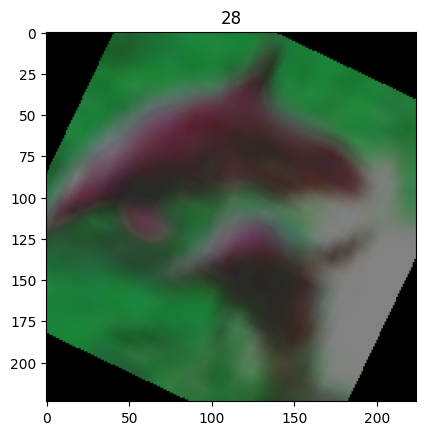

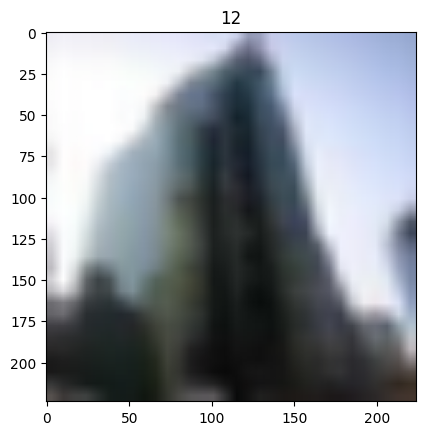

In [12]:
for i in range(1):
  sample = dataloader['train'].dataset[random.randint(0, len(dataloader['train']))]
  imageshow(sample)
for i in range(1):
  sample = dataloader['validation'].dataset[random.randint(0, len(dataloader['validation']))]
  imageshow(sample)

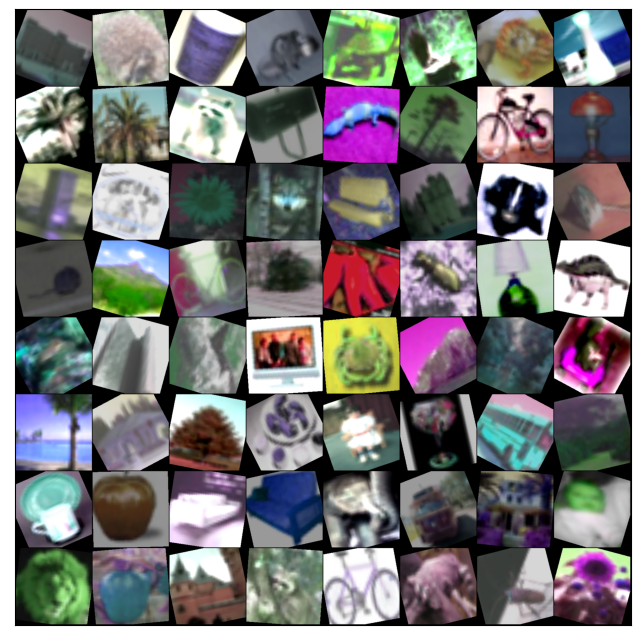

In [13]:
batchshow(dataloader['train'])

# Image Classification Model

In [14]:
class resnet50ft(nn.Module):
    def __init__(self, resnet50_weights=None):
        super(resnet50ft, self).__init__()
        self.resnet50ft = resnet50(weights=resnet50_weights)
        self.resnet50ft.fc = nn.Linear(self.resnet50ft.fc.in_features, len(trainset.classes))
        # freeze parameters
        for param in self.resnet50ft.parameters():
            param.requires_grad = False
        # unfreeze parameters
        for param in self.resnet50ft.layer4.parameters():
            param.requires_grad = True
        for param in self.resnet50ft.fc.parameters():
            param.requires_grad = True
    
    def forward(self, x):
        return self.resnet50ft(x)
    
    def get_params_to_update(self):
        params_to_update = []
        for param in self.resnet50ft.layer4.parameters():
            params_to_update.append(param)
        for param in self.resnet50ft.fc.parameters():
            params_to_update.append(param)
        return params_to_update

# Train & Test

In [15]:
def train(model, optimizer, criterion, dataloader, epochs=5, log_interval=100, init_epoch=0):
    model.train()

    iter = 0
    overfit = 0
    best_accuracy = -1.0
    
    for epoch in range(epochs):
        print('------------------------------------------------------------')
        for batch_idx, (x, y) in enumerate(dataloader['train']):
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            y_out = model(x)  #
            loss = criterion(y_out, y)
            loss.backward()
            optimizer.step() 

            if iter % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, 
                    batch_idx * len(x), 
                    len(dataloader['train'].dataset),
                    100. * batch_idx / len(dataloader['train']), 
                    loss.item()
                ))
            iter += 1
        
        accuracy_train = test(model, criterion, dataloader['train'], True)
        accuracy_test = test(model, criterion, dataloader['validation'], False)
        
        if accuracy_test > best_accuracy:
            best_accuracy = accuracy_test
            save_checkpoint('./checkpoint/ttemp/best-hw1p1B50-%i.pth' % init_epoch, model, optimizer)
        
        if epoch % 5 == 0:
            save_checkpoint('./checkpoint/ttemp/hw1p1B50-%i.pth' % (epoch + init_epoch), model, optimizer)
        
        
    save_checkpoint('./checkpoint/ttemp/f-%i-hw1p1B50.pth' % init_epoch, model, optimizer)

In [16]:
def test(model, criterion, dataloader, is_trainset):
    model.eval()

    total_loss = 0
    correct = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            
            y_out = model(x)
            total_loss += criterion(y_out, y).item()
            pred = y_out.max(1, keepdim=True)[1]
            correct += pred.eq(y.view_as(pred)).sum().item()

    total_loss /= len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)
    if is_trainset:
        print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)'.format(
            total_loss, 
            correct,
            len(dataloader.dataset),
            accuracy
        ))
    else:
        print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)'.format(
            total_loss, 
            correct,
            len(dataloader.dataset),
            accuracy
        ))
    return accuracy

In [17]:
model = resnet50ft(ResNet50_Weights.IMAGENET1K_V1)
model.to(device)
optimizer = optim.Adam(model.get_params_to_update(), lr=0.0002, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

In [18]:
print(model)

resnet50ft(
  (resnet50ft): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [19]:
# train(model, optimizer, criterion, dataloader, 30, init_epoch=0)

# Inference

In [20]:
new_model = resnet50ft()
new_model.to(device)
optimizer = optim.Adam(model.get_params_to_update(), lr=0.0002, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

In [21]:
load_checkpoint('./checkpoint/hw1p1B/best-hw1p1B50-0.pth', new_model, optimizer)
test(new_model, criterion, dataloader['train_origin'], False)
test(new_model, criterion, dataloader['validation'], False)

model loaded from ./checkpoint/hw1p1B//best-hw1p1B50-0.pth 
Test set: Average loss: 0.0003, Accuracy: 21239/22500 (94.3956%)
Test set: Average loss: 0.0016, Accuracy: 2006/2500 (80.2400%)


80.24

In [22]:
for i in range(0, 31, 5):
    load_checkpoint('./checkpoint/hw1p1B/hw1p1B50-%i.pth' % i, new_model, optimizer)
    test(new_model, criterion, dataloader['train_origin'], False)
    test(new_model, criterion, dataloader['validation'], False)

model loaded from ./checkpoint/hw1p1B/hw1p1B50-0.pth 
Test set: Average loss: 0.0019, Accuracy: 15584/22500 (69.2622%)
Test set: Average loss: 0.0021, Accuracy: 1686/2500 (67.4400%)
model loaded from ./checkpoint/hw1p1B/hw1p1B50-5.pth 
Test set: Average loss: 0.0012, Accuracy: 18048/22500 (80.2133%)
Test set: Average loss: 0.0016, Accuracy: 1855/2500 (74.2000%)
model loaded from ./checkpoint/hw1p1B/hw1p1B50-10.pth 
Test set: Average loss: 0.0009, Accuracy: 18906/22500 (84.0267%)
Test set: Average loss: 0.0016, Accuracy: 1923/2500 (76.9200%)
model loaded from ./checkpoint/hw1p1B/hw1p1B50-15.pth 
Test set: Average loss: 0.0007, Accuracy: 19720/22500 (87.6444%)
Test set: Average loss: 0.0015, Accuracy: 1930/2500 (77.2000%)
model loaded from ./checkpoint/hw1p1B/hw1p1B50-20.pth 
Test set: Average loss: 0.0007, Accuracy: 19992/22500 (88.8533%)
Test set: Average loss: 0.0017, Accuracy: 1916/2500 (76.6400%)
model loaded from ./checkpoint/hw1p1B/hw1p1B50-25.pth 
Test set: Average loss: 0.0005, 